In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import ntpath
import cv2
import random 

import imgaug as ia
import imgaug.augmenters as iaa

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
#Lectura en crudo del fichero CSV generado, añadiendo los labels a cada columna
columnas = ['centro', 'izquierda', 'derecha', 'angulo', 'acelerador', 'freno', 'velocidad']
datos = pd.read_csv('driving_log.csv', names = columnas)

#Muestra en pantalla los 5 primeros elementos del fichero
datos.head()

,centro,izquierda,derecha,angulo,acelerador,freno,velocidad
0,C:\Users\webde\Desktop\3v2d\IMG\center_2019_08...,C:\Users\webde\Desktop\3v2d\IMG\left_2019_08_1...,C:\Users\webde\Desktop\3v2d\IMG\right_2019_08_...,0.000000,1.0,0,20.96597
1,C:\Users\webde\Desktop\3v2d\IMG\center_2019_08...,C:\Users\webde\Desktop\3v2d\IMG\left_2019_08_1...,C:\Users\webde\Desktop\3v2d\IMG\right_2019_08_...,-0.150000,1.0,0,21.75763
2,C:\Users\webde\Desktop\3v2d\IMG\center_2019_08...,C:\Users\webde\Desktop\3v2d\IMG\left_2019_08_1...,C:\Users\webde\Desktop\3v2d\IMG\right_2019_08_...,-0.300000,1.0,0,22.31801
3,C:\Users\webde\Desktop\3v2d\IMG\center_2019_08...,C:\Users\webde\Desktop\3v2d\IMG\left_2019_08_1...,C:\Users\webde\Desktop\3v2d\IMG\right_2019_08_...,-0.384107,1.0,0,23.01026
4,C:\Users\webde\Desktop\3v2d\IMG\center_2019_08...,C:\Users\webde\Desktop\3v2d\IMG\left_2019_08_1...,C:\Users\webde\Desktop\3v2d\IMG\right_2019_08_...,-0.190968,1.0,0,23.59531


In [3]:
#Función para obtener la 'hoja' del árbol perteneciente a la ruta absoluta de la imagen, que corresponde con su nombre
def get_tail(path):
  head, tail = ntpath.split(path) #Separando por "/", tail es el último elemento, y head todo lo anterior
  return tail

#Modificación de las 3 primeras columnas, correspondiente a la ruta de las imágenes
datos['centro'] = datos['centro'].apply(get_tail)
datos['izquierda'] = datos['izquierda'].apply(get_tail)
datos['derecha'] = datos['derecha'].apply(get_tail)

#Muestra en pantalla los 5 primeros elementos del fichero, con las rutas ya procesadas
datos.head()

,centro,izquierda,derecha,angulo,acelerador,freno,velocidad
0,center_2019_08_10_22_24_32_972.jpg,left_2019_08_10_22_24_32_972.jpg,right_2019_08_10_22_24_32_972.jpg,0.000000,1.0,0,20.96597
1,center_2019_08_10_22_24_33_041.jpg,left_2019_08_10_22_24_33_041.jpg,right_2019_08_10_22_24_33_041.jpg,-0.150000,1.0,0,21.75763
2,center_2019_08_10_22_24_33_115.jpg,left_2019_08_10_22_24_33_115.jpg,right_2019_08_10_22_24_33_115.jpg,-0.300000,1.0,0,22.31801
3,center_2019_08_10_22_24_33_183.jpg,left_2019_08_10_22_24_33_183.jpg,right_2019_08_10_22_24_33_183.jpg,-0.384107,1.0,0,23.01026
4,center_2019_08_10_22_24_33_256.jpg,left_2019_08_10_22_24_33_256.jpg,right_2019_08_10_22_24_33_256.jpg,-0.190968,1.0,0,23.59531


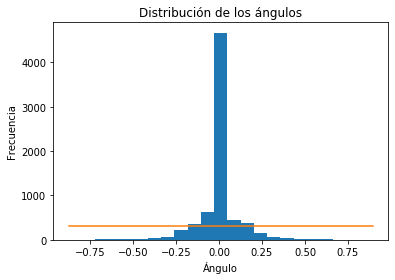

In [4]:
#Definición de las características del histograma
num_bins = 23
max_muestras_por_bin = 300

#Generación del histograma (sus variables serán usadas en la celda siguiente para procesar los elementos sobrantes)
hist, bins = np.histogram(datos['angulo'], num_bins)

#Dibujado del histograma
plt.hist(datos['angulo'], num_bins)

plt.xlabel('Ángulo')
plt.ylabel('Frecuencia')
plt.title("Distribución de los ángulos") 

#Línea representando max_muestras_por_bin sobre el histograma
plt.plot((np.min(datos['angulo']), np.max(datos['angulo'])), (max_muestras_por_bin, max_muestras_por_bin))

plt.show()

In [5]:
#-------------BALANCEO DEL DATASET------------------------

datos_preprocesados = datos.copy() #Copia del dataset original
elementos_a_eliminar = []

#Recorrido de cada bin
for i in range(num_bins):
  lista = []
#Recorrido de cada elemento del dataset: si el ángulo pertenece al bin que estamos recorriendo, lo 
#metemos en la lista
  for j in range(len(datos['angulo'])):
    if datos['angulo'][j] >= bins[i] and datos['angulo'][j] <= bins[i+1]:
      lista.append(j)
    
#Mezclamos los elementos que pertenecen al bin
  lista = shuffle(lista)
  #Nos quedamos con las "sobras" basado en el umbral que hayamos decidido (max_muestras_por_bin), para posteriormente
  #añadirlo a elementos_a_eliminar y utilizarla como lista con los elementos a eliminar en el dataset
  lista = lista[max_muestras_por_bin:]
  elementos_a_eliminar.extend(lista)

#Eliminamos dichos datos del dataset
datos_preprocesados.drop(datos_preprocesados.index[elementos_a_eliminar], inplace=True)

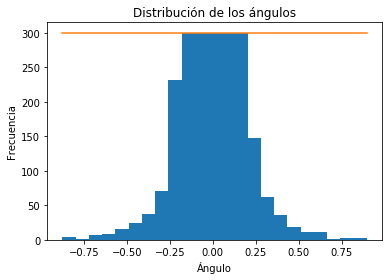

In [6]:
#Representación del histograma del dataset una vez procesado
plt.hist(datos_preprocesados['angulo'], num_bins)

plt.xlabel('Ángulo')
plt.ylabel('Frecuencia')
plt.title("Distribución de los ángulos")

#Línea representando max_muestras_por_bin sobre el histograma
plt.plot((np.min(datos_preprocesados['angulo']), np.max(datos_preprocesados['angulo'])), 
         (max_muestras_por_bin, max_muestras_por_bin))

plt.show()

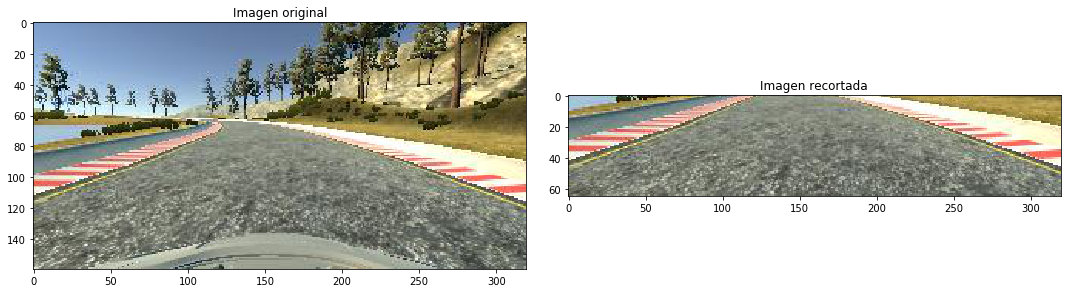

In [7]:
#Función de recortado de un fotograma
def recorte(img):
    img = img[70:135,:,:]
    return img

#Lectura del fotograma de prueba (fotograma_prueba.jpg debe encontrarse en la misma carpeta que este notebook)
imagen_original = mpimg.imread('fotograma_prueba.jpg')

#Uso de la función recorte para recortar el fotograma
imagen_recortada = recorte(imagen_original) 

#Generación conjunta de las imágenes para su comparación
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(imagen_original)
axs[0].set_title('Imagen original')
axs[1].imshow(imagen_recortada)
axs[1].set_title('Imagen recortada')

plt.show()

In [8]:
#Obtención de las imágenes y sus ángulos del dataset
def get_imgs_y_angulos(datos):
    imagenes = []
    angulos = []
    for i in range(len(datos)):
        elemento = datos.iloc[i]
        
        angulo = elemento[3]
        
        #Imagen central
        imagen_centro = elemento[0]
        imagenes.append(os.path.join('IMG/', imagen_centro))
        angulos.append(angulo)
        
        #Imagen izquierda
        imagen_izquierda = elemento[1]
        imagenes.append(os.path.join('IMG/', imagen_izquierda))
        angulos.append(angulo + 0.2)
        
        #Imagen derecha
        imagen_derecha = elemento[2]
        imagenes.append(os.path.join('IMG/', imagen_derecha))
        angulos.append(angulo - 0.2)
        
    imagenes = np.asarray(imagenes)
    angulos = np.asarray(angulos)
    
    return imagenes, angulos

In [9]:
imagenes, angulos = get_imgs_y_angulos(datos_preprocesados)
print("Número de imágenes:", len(imagenes))

Número de imágenes: 6576


In [10]:
#División del dataset en conjuntos de entrenamiento y prueba
x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(imagenes, angulos, train_size=0.8)

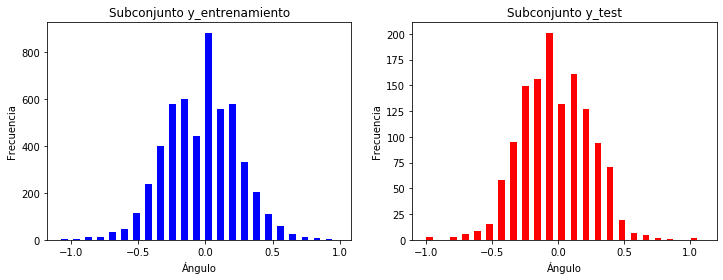

In [11]:
#Histogramas comparativos de los elementos "etiquetas" (y_, ángulos de dirección) en los dos conjuntos creados
fig, ejes = plt.subplots(1,2, figsize=(12,4))

ejes[0].hist(y_entrenamiento, bins=num_bins, width=0.05, color='blue')
ejes[0].set_title('Subconjunto y_entrenamiento')
ejes[0].set_xlabel('Ángulo')
ejes[0].set_ylabel('Frecuencia')

ejes[1].hist(y_test, bins=num_bins, width=0.05, color='red')
ejes[1].set_title('Subconjunto y_test')
ejes[1].set_xlabel('Ángulo')
ejes[1].set_ylabel('Frecuencia')

plt.show()

In [12]:
def iluminacion(img):
    iluminacion = iaa.Multiply((0.2, 1.3))
    img = iluminacion.augment_image(img)
    
    return img

def zooming(img):
    zooming = iaa.Affine(scale={"x": (1.0, 1.4), "y": (1.0, 1.4)})
    img = zooming.augment_image(img)
    
    return img

def desplazamiento(img):
    desplazamiento = iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
    img = desplazamiento.augment_image(img)
    
    return img

def volteo(img, angulo):
    volteo = iaa.Fliplr(1.0)
    img = volteo.augment_image(img)
    angulo = -angulo
    
    return img, angulo

In [13]:
def aumento_aleatorio(img, angulo):
    img = mpimg.imread(img)
    
    if np.random.random_sample() < 0.5:
        img = iluminacion(img)
        
    if np.random.random_sample() < 0.5:
        img = zooming(img)
        
    if np.random.random_sample() < 0.5:
        img = desplazamiento(img)
        
    if np.random.random_sample() < 0.5:
        img, angulo = volteo(img, angulo)
    
    return img, angulo

In [14]:
# img_original = mpimg.imread('fotograma_prueba.jpg')
# img_zooming = zooming(img_original)
# img_desplazada = desplazamiento(img_original)
# img_iluminada = iluminacion(img_original)
# img_volteada, _ = volteo(img_original, 0)

# fig, ejes = plt.subplots(1,2, figsize=(13,5))

# ejes[0].imshow(img_original)
# ejes[0].set_title('Imagen original')
# ejes[1].imshow(img_volteada)
# ejes[1].set_title('Imagen volteada horizontalmente')

# plt.show()

In [15]:
#-----CONJUNTO DE FUNCIONES PARA EL PREPROCESAMIENTO DE IMÁGENES----
def recorte(img):
    img = img[70:135,:,:] 
    return img

def RGBaYUV(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) 
    return img

def RGBaGRAY(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def redimensionar_imagen(img, x, y):
    img = cv2.resize(img, (x, y))
    return img

def normalizar_imagen(img):
    img = img/255
    return img

In [16]:
#Función de preprocesamiento de imágenes para el modelo de LeNet-5
def img_preproceso_lenet5(img):
    
    img = recorte(img)
    img = RGBaGRAY(img)
    img = redimensionar_imagen(img, 32, 32)
    img = img[:, :, np.newaxis]
    img = normalizar_imagen(img)
    return img

#Función de preprocesamiento de imágenes para el modelo de NVIDIA
def img_preproceso_nvidia(img):
    
    img = recorte(img)
    img = RGBaYUV(img)
    img = redimensionar_imagen(img, 200, 66)
    img = normalizar_imagen(img)
    return img

In [17]:
def batch_generator(imgs, angulos, batch_size, modo):
    
    while True:
        batch_imgs = []
        batch_angulos = []
        
        for i in range(batch_size):
            #Número aleatorio que actuará de índice para el conjunto de imágenes
            num_aleatorio = random.randint(0, len(imgs)-1)
            
            if modo == 'entrenamiento':
                img, angulo = aumento_aleatorio(imgs[num_aleatorio], angulos[num_aleatorio])
                
            else:
                img = mpimg.imread(imgs[num_aleatorio])
                angulo = angulos[num_aleatorio]
            
            img = img_preproceso_nvidia(img) #CAMBIAR en función del modelo neuronal usado
            batch_imgs.append(img) 
            batch_angulos.append(angulo)
            
        yield(np.asarray(batch_imgs), np.asarray(batch_angulos))

In [18]:
#Procesamiento de todas las imágenes de los subconjuntos x_entrenamiento y x_test 

#ESTE PROCESAMIENTO PASA AHORA A REALIZARSE DENTRO DEL GENERATOR

#Procesamiento para el modelo LeNet-5
# x_entrenamiento = np.array([img_preproceso_lenet5(x) for x in x_entrenamiento])
# x_test = np.array([img_preproceso_lenet5(x) for x in x_test])

#Procesamiento para el modelo NVIDIA
# x_entrenamiento = np.array([img_preproceso_nvidia(x) for x in x_entrenamiento])
# x_test = np.array([img_preproceso_nvidia(x) for x in x_test])

In [19]:
import keras
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

Using TensorFlow backend.


In [20]:
def modelo_lenet5():
    modelo = Sequential()

    modelo.add(Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1)))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    modelo.add(Conv2D(16, (5, 5), activation='relu'))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    modelo.add(Conv2D(120, (5, 5), activation='relu'))
    
    modelo.add(Flatten())

    modelo.add(Dense(84, activation='relu'))

    modelo.add(Dense(1))
    
    optimizador = Adam(lr=1e-3)
    modelo.compile(loss='mse', optimizer=optimizador)
    
    return modelo

def modelo_nvidia():
    modelo = Sequential()
    
    modelo.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    modelo.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    modelo.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    modelo.add(Conv2D(64, (3, 3), activation='elu'))
    modelo.add(Conv2D(64, (3, 3), activation='elu'))
    
    modelo.add(Flatten())
    
    modelo.add(Dense(100, activation='elu'))
    modelo.add(Dense(50, activation='elu'))
    modelo.add(Dense(10, activation='elu'))
    modelo.add(Dense(1))
    
    optimizador = Adam(lr=1e-3)
    modelo.compile(loss='mse', optimizer=optimizador)
    
    return modelo

In [ ]:
#Creación y resumen del modelos neuronal de LeNet-5 creado
modelo_lenet = modelo_lenet5()
print(modelo_lenet.summary())

In [21]:
#Creación y resumen del modelo neuronal de NVIDIA creado
modelo_nvidia = modelo_nvidia()
print(modelo_nvidia.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [ ]:
#LECTURA DE MODELOS EXPORTADOS
#modelo_lenet = load_model('modelo_lenet_elu.h5')

In [ ]:
#ENTRENAMIENTO DEL MODELO DE LENET-5
#---Hay que haber preprocesado las imágenes con la función img_preproceso_lenet5 en el batch_generator.  
#---En caso de haberlo hecho con img_preproceso_nvidia, hay que reiniciar el kernel y volverlo a ejecutar
#---con la función adecuada.
entrenamiento_lenet = modelo_lenet.fit_generator(batch_generator(x_entrenamiento, y_entrenamiento, 100, 'entrenamiento'), 
                                                   steps_per_epoch=200, 
                                                   epochs=10, 
                                                   validation_data=batch_generator(x_test, y_test, 100, ''),
                                                   validation_steps=200, 
                                                   verbose=1, 
                                                   shuffle=1)

In [ ]:
#Representación de los valores de LOSS por cada época en el modelo de LeNet-5 entrenado
plt.plot(entrenamiento_lenet.history['loss'])
plt.plot(entrenamiento_lenet.history['val_loss'])

plt.legend(['Entrenamiento', 'Validación'])
plt.title('Loss')
plt.xlabel('Época')

#print(entrenamiento_lenet.history['val_loss'][39] - entrenamiento_lenet.history['loss'][39])
plt.show()

In [ ]:
modelo_lenet.save("modelo_lenet.h5")

In [22]:
#ENTRENAMIENTO DEL MODELO DE NVIDIA
#---Hay que haber preprocesado las imágenes con la función img_preproceso_nvidia en el batch_generator. 
#---En caso de haberlo hecho con img_preproceso_lenet5, hay que reiniciar el kernel y volverlo a ejecutar
#---con la función adecuada.
#entrenamiento_nvidia = modelo_nvidia.fit(x_entrenamiento, y_entrenamiento, epochs=40, validation_data=(x_test, y_test), 
#                       batch_size=100, verbose=1, shuffle=1)

entrenamiento_nvidia = modelo_nvidia.fit_generator(batch_generator(x_entrenamiento, y_entrenamiento, 100, 'entrenamiento'), 
                                                   steps_per_epoch=300, 
                                                   epochs=15, 
                                                   validation_data=batch_generator(x_test, y_test, 100, ''),
                                                   validation_steps=200, 
                                                   verbose=1, 
                                                   shuffle=1)

Epoch 1/15
300/300 [==============================] - 117s 391ms/step - loss: 0.1045 - val_loss: 0.0486
Epoch 2/15
300/300 [==============================] - 115s 382ms/step - loss: 0.0522 - val_loss: 0.0398
Epoch 3/15
300/300 [==============================] - 113s 378ms/step - loss: 0.0491 - val_loss: 0.0356
Epoch 4/15
300/300 [==============================] - 114s 381ms/step - loss: 0.0453 - val_loss: 0.0298
Epoch 5/15
300/300 [==============================] - 117s 389ms/step - loss: 0.0420 - val_loss: 0.0335
Epoch 6/15
300/300 [==============================] - 112s 374ms/step - loss: 0.0404 - val_loss: 0.0289
Epoch 7/15
300/300 [==============================] - 113s 377ms/step - loss: 0.0374 - val_loss: 0.0295
Epoch 8/15
300/300 [==============================] - 115s 384ms/step - loss: 0.0361 - val_loss: 0.0263
Epoch 9/15
300/300 [==============================] - 117s 390ms/step - loss: 0.0342 - val_loss: 0.0256
Epoch 10/15
300/300 [==============================] - 116s 387m

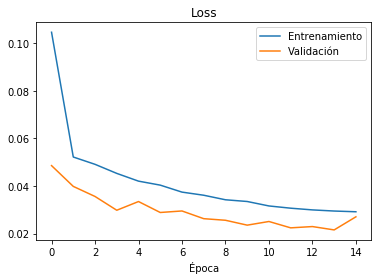

In [23]:
#Representación de los valores de LOSS por cada época en el modelo de NVIDIA entrenado
plt.plot(entrenamiento_nvidia.history['loss'])
plt.plot(entrenamiento_nvidia.history['val_loss'])

plt.legend(['Entrenamiento', 'Validación'])
plt.title('Loss')
plt.xlabel('Época')

plt.show()
#print(entrenamiento_nvidia.history['val_loss'][9] - entrenamiento_nvidia.history['loss'][9])

In [24]:
modelo_nvidia.save("modelo_nvidia.h5")